#  Calculating the synchronization timescale t_sync at ZAMS

In this notebook, we test if the synchronization timescale is short relative to the mainsequence timescale for our best fitting model

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import os

import astropy.units as u
import astropy.constants as const
import mesaPlot as mp

home_dir = os.path.expanduser("~")
data_root_dir    = home_dir + '/ceph/ksharpe/results/' #'/ceph/MESAoutput/ksharpe_proj/'
inlist_dirs = ['dense_mass_hastings_grid', 'dens_mass_grid_run' 'dense_mass_div3winds_grid',  'CHE_x3winds']

def Kepler(m1 = 1*u.Msun, m2 = 1*u.Msun, P = 1*u.day):
    m1 = m1.to(u.kg)
    m2 = m2.to(u.kg)
    P = P.to(u.s)
    a = (const.G * (m1 + m2) * (P**2/4*np.pi**2) )**(1/3)
    return a.to(u.Rsun)


## Import necessary model data 
for t_sync calculations from models, save as separate table

In [219]:
# Get a list of all the folders in the directory
dir = data_root_dir + '/dense_mass_hastings_grid/'
 
#folder with best-fit model
subdir = 153
           
m=mp.MESA()
m.loadHistory(f = dir + str(subdir) + '/LOGS1')

# ALL data column names
print(m.hist.data.dtype.names)

# We adopt the first moment that X drops below 0.74 as ZAMS
def find_ZAMS(data):
    return next((i for i, x in enumerate(data) if x < 0.735), None)

ZAMS_i = find_ZAMS(m.hist.center_h1)
print(f'ZAMS age = {m.hist.star_age[ZAMS_i]} ')

# We adopt the time when center_he4 is 0.99 as the end of the MS
def find_end_of_MS(data):
    return next((i for i, x in enumerate(data) if x > 0.99), None)

TAMS_i = find_end_of_MS(m.hist.center_he4)

# # #plot HR diagram (to show ZAMS and TAMS makes sense)
# plt.scatter(m.hist.log_Teff, m.hist.log_L , c =  m.hist.center_he4 )
# plt.scatter(m.hist.log_Teff[ZAMS_i], m.hist.log_L[ZAMS_i], c='r', s = 50)
# plt.scatter(m.hist.log_Teff[TAMS_i], m.hist.log_L[TAMS_i], c='r', s = 50)
# plt.colorbar(label = 'center He4')
# plt.gca().invert_xaxis() 
# plt.xlabel('log(Teff)')
# plt.ylabel('log(L)')
# plt.show()



('model_number', 'star_age', 'star_mass', 'star_mdot', 'log_dt', 'log_total_angular_momentum', 'he_core_mass', 'log_Teff', 'log_L', 'log_R', 'surf_avg_v_rot', 'surf_avg_v_crit', 'surf_avg_Lrad_div_Ledd', 'rotational_mdot_boost', 'center_h1', 'center_he4', 'center_c12', 'surface_h1', 'surface_he4', 'surface_c12', 'surface_n14', 'surface_o16', 'surface_ne20', 'surface_mg24', 'model_number.1', 'age', 'period_days', 'rl_1', 'rl_2', 'lg_wind_mdot_1', 'J_orb', 'J_spin_1', 'Jdot')
ZAMS age = 38796.40649441341 


## Hurley et al 2002 - Radiative envelopes *(Fiducial)*
Hut radiative in MESA

[Hurley et al. 2002, eq 44](https://articles.adsabs.harvard.edu/pdf/2002MNRAS.329..897H), (but timescale for synchronization was derived by [Zahn (1975)](https://articles.adsabs.harvard.edu//full/1975A%26A....41..329Z/0000331.000.html) )

\begin{equation}
\frac{1}{\tau_{sync}} = 52^{5/3} \left( \frac{GM}{R^3} \right)^{1/2} \frac{MR^2}{I} q^2_2 (1 + q_2)^{5/6} E_2 \left(\frac{R}{a} \right)^{17/2}
\end{equation}

(same as [eq. 2 in de Mink et al. 2009](https://www.aanda.org/articles/aa/pdf/2009/13/aa11439-08.pdf) )


M and R are the mass and radius of the star, and a the separation

Here, $q_2 = \frac{M_{companion}}{M_{star}}$ (=1 for us)

E2 is a second-order tidal coefficient which can be fitted to values given by Zahn (1975),
$E_2 = 1.592 \times 10^{-9} M^{2.84} $

$I \approx (2/5) M R^2$ is the moment of inertia of the perturbed star

Substituting all this we get

\begin{equation}
\frac{1}{\tau_{sync}} = (5/2) \cdot 52^{5/3} \cdot E_2 \cdot (GM)^{1/2} R^{7} a^{-8.5}
\end{equation}

In [226]:
# Simplified version
def tau_sync_Hurley_rad(Mstar = 1*u.Msun, R=1*u.Rsun, a=1 *u.Rsun):
    E_2 = (1.592*1e-9 * Mstar**2.84).value #unitless coefficient
    grav_const = const.G.to(u.Rsun**3/u.Msun/u.year**2) # In astro units
    
    return 1/((5/2.) * 52**(5/3) * E_2  * (grav_const * Mstar)** 0.5 * R**7 * a**(-8.5))

# For best fitting model
a_ZAMS =  Kepler(m1 = m.hist.star_mass[ZAMS_i] * u.Msun, m2 =m.hist.star_mass[ZAMS_i] * u.Msun,
                 P = m.hist.period_days[ZAMS_i] * u.day)

print('a_ZAMS', a_ZAMS)

t_sync_rad = tau_sync_Hurley_rad(m.hist.star_mass[ZAMS_i] * u.Msun, 10**m.hist.log_R[ZAMS_i] * u.Rsun, a_ZAMS)
print(f'Synchronization timescale for best fitting model {np.round(t_sync_rad)}, under the assumption of radiative damping')

# Main sequence lifetime for best fitting model
MS_lifetime = (m.hist.star_age[TAMS_i] - m.hist.star_age[ZAMS_i] )*u.year

print(f'This is {np.round(t_sync_rad/MS_lifetime, 2) *100} % of the main sequence lifetime')


a_ZAMS 217.21657885655745 solRad
Synchronization timescale for best fitting model 58737.0 yr, under the assumption of radiative damping
This is 2.0 % of the main sequence lifetime


# Hurley et al 2002 - Convective envelopes 
## (or “turbulent viscosity” )
Hut convective in MESA, Eq 27  in [Hurley et al. 2002](https://articles.adsabs.harvard.edu/pdf/2002MNRAS.329..897H),  
Synchronization timescale as derived by [Zahn 1977 eg 6.1](https://articles.adsabs.harvard.edu/pdf/1977A%26A....57..383Z) :

\begin{equation}
\frac{1}{\tau_{sync}} = 3\left(\frac{k}{t_{tide}}\right)_c  \frac{M R^2}{I} q_2^2 \left(\frac{R}{a}\right)^6
\end{equation}

with $t_{tide}$ the time-scale on which significant changes in the orbit take place through tidal evolution.


Following [eq. 1 in de Mink et al. 2009](https://www.aanda.org/articles/aa/full_html/2009/13/aa11439-08/aa11439-08.html), this is can be approximated as:

\begin{equation}
\tau_{sync} = f_{turb}\times q^{-2} \left(\frac{a}{R}\right)^{6} yr
\end{equation}

Where we assume that $f_{turb} \approx 1$, because Zahn (1977) showed that this adequately explains the observed orbital period below which tides lead to synchronization due to the strong dependence of $R/a$



In [227]:
"""
Hurley et al 2002 from Hut
values of k for realistic stars are 0.1-0.01, 
more centrally condensed star structure means lower k
tau is a small lag time introduced via dissipation, 
such that the amplitude and direction of the tides are slightly changed
t_tide = R^3/(G M tau)
assuming spherical moment of inertia
"""
# def tau_hut(tau, k, M, R, a):
#     T_timescale = np.divide(np.power(R,3), M)/const.G/tau
#     return np.power(np.multiply(3*np.divide(k, T_timescale), 
#                                 np.power(np.divide(R, a), 6))*5/2, 
#                     -1).to(u.year) 
#     #test
# tau_hut(1*u.second, 0.1, 1*u.Msun, 1*u.Rsun, semimajor(1*u.Msun, 1*u.year))


#Zahn 1977
def tau_zahn_conv(R = 1*u.Rsun, a = 1*u.Rsun, f_turb = 1.):
    return (f_turb * (a/R)**2)*u.yr

t_sync_conv = tau_zahn_conv(10**m.hist.log_R[ZAMS_i] * u.Rsun, a_ZAMS)

print(f'Synchronization timescale for best fitting model {np.round(t_sync_rad)}, under the assumption of turbulent viscosity damping')
print(f'This is {np.round(t_sync_conv/MS_lifetime, 4) *100} % of the main sequence lifetime')



Synchronization timescale for best fitting model 58737.0 yr, under the assumption of turbulent viscosity damping
This is 0.01 % of the main sequence lifetime


## Zahn 2008 - weak friction approximation Viscosity

(seems very similar to Hut treatment for convective envelopes)
\begin{equation}
\frac{1}{\tau_{sync}} = \frac{1}{t_{diss}} \left(\frac{\omega - \Omega}{\omega}\right) q^2 \frac{M R^2}{I} \left(\frac{R}{a}\right)^6
\end{equation}

\begin{equation}
\tau_{sync} = t_{diss} \left(\frac{\omega}{\omega - \Omega}\right) q^{-2} \frac{I}{M R^2} \left(\frac{a}{R}\right)^6
\end{equation}

where $\omega$ is the orbital angular velocity and $\Omega$ is the rotational angular velocity

https://arxiv.org/pdf/0807.4870.pdf (eq 2.5)

In [21]:
# zahn 2008

# assuming spherical moment of inertia
def tau_zahn_visc(t_diss, P, Omega, M, R, a):
    omega = 2*np.pi*np.power(P, -1)
    return (t_diss*np.multiply(np.divide(omega, np.abs(omega-Omega)), 
                              2/5*np.power(np.divide(a, R), 6))).to(u.year)
    
    
# test
tau_zahn_visc(1*u.s, 1*u.year, 10/u.s, 1*u.Msun, 1*u.Rsun, Kepler(1*u.Msun, 1*u.year))

<Quantity 0.02494896 yr>

## Yoon, Woosley, Langer 2010

\begin{equation}
\tau_{sync} = f_{sync} \frac{1.44\times 10^{1.6}}{q(1+q)^{3/8}} \left(\frac{L_\odot}{L}\right)^{1/4} \left(\frac{M_\odot}{M}\right)^{1/8} \left(\frac{R}{R_\odot}\right)^{9/8} \left(\frac{d}{R}\right)^{33/8} years
\end{equation}

[YWL 2010, equation 3](https://iopscience.iop.org/article/10.1088/0004-637X/725/1/940/pdf)

In [10]:
#Yoon, Woosley, Langer 2010 
def tau_YWL2010(f_sync, L, M, R, a):
    return f_sync/2**(3/8)*1.44*10**(1.6)*np.multiply(np.multiply(np.power(L/u.Lsun, -1/4), np.power(M/u.Msun, -1/8)), 
                                             np.multiply(np.power(R/u.Rsun, 9/8), np.power(np.divide(a,R), 33/8)))*u.year
    
    
# test
tau_YWL2010(1, 1*u.Lsun, 1*u.Msun, 1*u.Rsun, semimajor(1*u.Msun, 1*u.year))

# Repeat exercise for all models


In [ ]:

# Get a list of all the folders in the directory
dir = data_root_dir + '/dense_mass_hastings_grid/'

verbose = False

radiative_sync_times = np.array([])
MS_lifetimes = np.array([])
for subdir in os.listdir(dir):
    if subdir in ['photos', 'LOGS', 'LOGS1']:
        continue
    if os.path.isdir(os.path.join(dir, subdir)):
        try:
            # print(subdir)
            m=mp.MESA()
            m.loadHistory(f = dir + str(subdir) + '/LOGS1')
            
            # Find start and end of MS
            ZAMS_i = find_ZAMS(m.hist.center_h1)
            TAMS_i = find_end_of_MS(m.hist.center_he4)
            if ZAMS_i is not None and TAMS_i is not None:
                MS_lifetime = (m.hist.star_age[TAMS_i] - m.hist.star_age[ZAMS_i] )*u.year

                # Separation at ZAMS
                a_ZAMS =  Kepler(m1 = m.hist.star_mass[ZAMS_i] * u.Msun, m2 =m.hist.star_mass[ZAMS_i] * u.Msun,
                                P = m.hist.period_days[ZAMS_i] * u.day)

                # Synchronization timescale for a radiative envelope
                t_sync_rad = tau_sync_Hurley_rad(m.hist.star_mass[ZAMS_i] * u.Msun, 10**m.hist.log_R[ZAMS_i] * u.Rsun, a_ZAMS)
                
                # Append to lists
                radiative_sync_times.append(t_sync_rad.value)
                MS_lifetimes.append(MS_lifetime.value)
                
                if verbose:
                    print(f'Mzams = {m.hist.star_mass[ZAMS_i]}, Pzams =  {m.hist.period_days[ZAMS_i]}')
                    print(f'a_ZAMS = {a_ZAMS}', ' Rzams', 10**m.hist.log_R[ZAMS_i] * u.Rsun)
                    print(f'age ZAMS = {m.hist.star_age[ZAMS_i]} , MS lifetime = {MS_lifetime}')
                    print(f'Synchronization timescale= {np.round(t_sync_rad)}, under the assumption of radiative damping')
                    print(f'This is {np.round(t_sync_rad/MS_lifetime, 2) *100} % of the main sequence lifetime')

                    continue
        except:
            print(f'Error for model {subdir}')
        else:
            continue
        
        


Error for model 88
Error for model 36
Error for model 83
Error for model 10
Error for model 11
Error for model 49
Error for model .mesa_temp_cache
Error for model 14


Radiative sync times: max fraction of MS 121.89%, min fraction of MS 0.15%


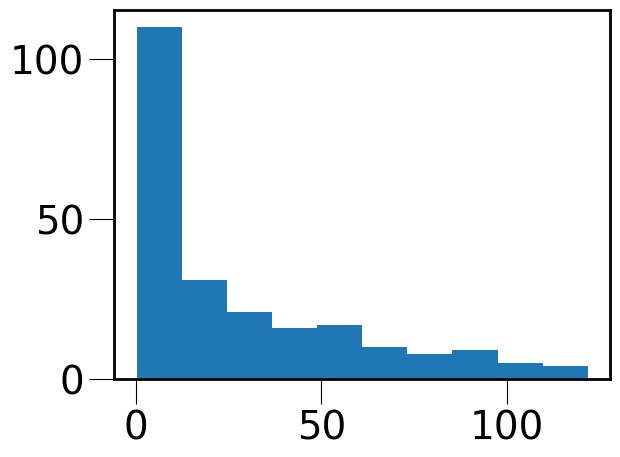

In [ ]:
# tsyncRad_tMS = np.array(radiative_sync_times)/np.array(MS_lifetimes) 
# print( tsyncRad_tMS)


print(f'Radiative sync times: max fraction of MS {np.round(np.max(tsyncRad_tMS)*100, 2)}%, min fraction of MS {np.round(np.min(tsyncRad_tMS)*100,2)}%' )

plt.hist(tsyncRad_tMS*100)
plt.show()
